# Using quantum kernel - Method 2

- **Goal**: classify 1-qubit states as *pure* vs *mixed* using a quantum-inspired feature map (Uhlmann fidelity) and a classical linear SVM.

- **Data generation**: `build_purity_classification_dataset` creates datasets of Bloch-vector estimates (columns like `X_mean`, `Y_mean`, `Z_mean`) and a binary label (`is_pure`). Number of measurement shots is controlled by `N_SHOTS`.

- **Feature map**: implemented `uhlmann_feature_map(R)` that maps Bloch vectors $r = (x,y,z)$ to $Φ(r) ∈ R^5$:

    $$Φ(r) = \frac{1}{\sqrt{2}}(1, rx, ry, rz, \sqrt{1 − ||r||²})$$

    chosen so that $<Φ(r), Φ(s)>$ equals Uhlmann fidelity for single-qubit states (with numeric clipping to keep sqrt argument valid).

- **Training pipeline**:
    - Extract R = df[['X_mean','Y_mean','Z_mean']].
    - Compute $Φ$ = uhlmann_feature_map(R).
    - Stratified `train_test_split` to preserve class ratio.
    - Train `LinearSVC` on $Φ$ (linear classifier approximates using the fidelity kernel).
    - Predict and evaluate.

- **Evaluation**: compute accuracy, classification report, confusion matrix and per-class F1 scores on the test set.

- **Experiments / analyses performed**:
    - Sweep over mixed-state proportion and plot accuracy & per-class F1 vs proportion.
    - Sweep over dataset size (`n_states_total`) and plot performance vs dataset size.
    - Sweep over number of shots and plot performance vs shots (log-scale for shots).
    - For each experiment: regenerate dataset, recompute $Φ$, retrain SVM, collect metrics and plot.

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

from sklearn.model_selection import GridSearchCV

from clf_dtSet_hugo import build_purity_classification_dataset

In [26]:
N_SHOTS = 1000

# Dataset creation
df, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
)

print(f"Dataset shape: {df.shape}")
print(f"Labels distribution:\n{y.value_counts()}")
print(f"\nDataset columns:\n{df.columns.tolist()}")
print(f"\X columns (à revoir):\n{X.columns.tolist()}")

df.head()

Dataset shape: (5000, 14)
Labels distribution:
label_purity
1    2500
0    2500
Name: count, dtype: int64

Dataset columns:
['X_mean', 'Y_mean', 'Z_mean', 'X_real', 'Y_real', 'Z_real', 'theta_ideal', 'phi_ideal', 'X_ideal', 'Y_ideal', 'Z_ideal', 'bloch_radius_real', 'is_pure', 'label_purity']
\X columns (à revoir):
['X_mean', 'Y_mean', 'Z_mean', 'bloch_radius_real']


,X_mean,Y_mean,Z_mean,X_real,Y_real,Z_real,theta_ideal,phi_ideal,X_ideal,Y_ideal,Z_ideal,bloch_radius_real,is_pure,label_purity
0,0.020,-0.070,-0.992,0.075612,-0.070992,-0.988324,2.988630,5.295020,0.083836,-0.127229,-0.988324,0.993751,True,1
1,-0.078,0.428,-0.008,-0.109132,0.423414,0.004087,1.558157,1.975693,-0.393892,0.919070,0.012639,0.437271,False,0
2,0.140,-0.276,-0.604,0.100225,-0.259867,-0.639498,2.668393,4.955356,0.109643,-0.442351,-0.890115,0.697520,False,0
3,0.282,-0.248,-0.308,0.250980,-0.273969,-0.338658,2.484070,5.567498,0.461205,-0.401003,-0.791509,0.502732,False,0
4,-0.148,-0.302,0.124,-0.116011,-0.264752,0.136257,1.324157,4.463333,-0.239030,-0.939818,0.244147,0.319559,False,0


In [27]:
# Feature map based on Uhlmann fidelity for 1-qubit states
def uhlmann_feature_map(R: np.ndarray) -> np.ndarray:
    """
    R : array (n_samples, 3) = vecteurs de Bloch (X_mean, Y_mean, Z_mean)
    Retour : Phi (n_samples, 5) tel que
             <Phi(r), Phi(s)> = F_uhlmann(r, s) pour des états de 1 qubit.
    """
    R = np.asarray(R, dtype=float)          # (n,3)
    # ||r||^2
    r2 = np.sum(R**2, axis=1, keepdims=True)   # (n,1)

    # Numerical stability: clip ||r||^2 in [0,1]
    r2 = np.clip(r2, 0.0, 1.0)

    # sqrt(1 - ||r||^2)
    sqrt_term = np.sqrt(1.0 - r2)          # (n,1)

    # Ones vector
    ones = np.ones_like(r2)                # (n,1)

    # Whole feature map
    Phi = np.concatenate([ones, R, sqrt_term], axis=1)   # (n,5)

    # Multiply by 1/sqrt(2)
    Phi /= np.sqrt(2.0)

    return Phi


In [28]:
# We are using the measurements means as features
R = df[['X_mean', 'Y_mean', 'Z_mean']].values

# binary labels: pure vs mixed
y = df['is_pure'].astype(int).values

# Compute feature map
Phi = uhlmann_feature_map(R)   # (n_samples, 5)

In [29]:
# Train/test split
Phi_train, Phi_test, y_train, y_test = train_test_split(
    Phi, y,
    test_size=0.2,       # 20% test
    random_state=42,
    stratify=y           # keep class proportions
)

In [30]:
# Train Linear SVM
clf = LinearSVC(
    C=1.0,          # we can change C later
    max_iter=10_000
)

clf.fit(Phi_train, y_train)

,"penalty penalty: {'l1', 'l2'}, default='l2'Specifies the norm used in the penalization. The 'l2'penalty is the standard used in SVC. The 'l1' leads to ``coef_``vectors that are sparse.",'l2'
,"loss loss: {'hinge', 'squared_hinge'}, default='squared_hinge'Specifies the loss function. 'hinge' is the standard SVM loss(used e.g. by the SVC class) while 'squared_hinge' is thesquare of the hinge loss. The combination of ``penalty='l1'``and ``loss='hinge'`` is not supported.",'squared_hinge'
,"dual dual: ""auto"" or bool, default=""auto""Select the algorithm to either solve the dual or primaloptimization problem. Prefer dual=False when n_samples > n_features.`dual=""auto""` will choose the value of the parameter automatically,based on the values of `n_samples`, `n_features`, `loss`, `multi_class`and `penalty`. If `n_samples` < `n_features` and optimizer supportschosen `loss`, `multi_class` and `penalty`, then dual will be set to True,otherwise it will be set to False... versionchanged:: 1.3 The `""auto""` option is added in version 1.3 and will be the default in version 1.5.",'auto'
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.For an intuitive visualization of the effects of scalingthe regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"multi_class multi_class: {'ovr', 'crammer_singer'}, default='ovr'Determines the multi-class strategy if `y` contains more thantwo classes.``""ovr""`` trains n_classes one-vs-rest classifiers, while``""crammer_singer""`` optimizes a joint objective over all classes.While `crammer_singer` is interesting from a theoretical perspectiveas it is consistent, it is seldom used in practice as it rarely leadsto better accuracy and is more expensive to compute.If ``""crammer_singer""`` is chosen, the options loss, penalty and dualwill be ignored.",'ovr'
,"fit_intercept fit_intercept: bool, default=TrueWhether or not to fit an intercept. If set to True, the feature vectoris extended to include an intercept term: `[x_1, ..., x_n, 1]`, where1 corresponds to the intercept. If set to False, no intercept will beused in calculations (i.e. data is expected to be already centered).",True
,"intercept_scaling intercept_scaling: float, default=1.0When `fit_intercept` is True, the instance vector x becomes ``[x_1,..., x_n, intercept_scaling]``, i.e. a ""synthetic"" feature with aconstant value equal to `intercept_scaling` is appended to the instancevector. The intercept becomes intercept_scaling * synthetic featureweight. Note that liblinear internally penalizes the intercept,treating it like any other term in the feature vector. To reduce theimpact of the regularization on the intercept, the `intercept_scaling`parameter can be set to a value greater than 1; the higher the value of`intercept_scaling`, the lower the impact of regularization on it.Then, the weights become `[w_x_1, ..., w_x_n,w_intercept*intercept_scaling]`, where `w_x_1, ..., w_x_n` representthe feature weights and the intercept weight is scaled by`intercept_scaling`. This scaling allows the intercept term to have adifferent regularization behavior compared to the other features.",1
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to ``class_weight[i]*C`` forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: int, default=0Enable verbose output. Note that this setting takes advantage of aper-process runtime setting in liblinear that, if enabled, may not workproperly in a multithreaded context.",0
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo rand

In [31]:
# Evaluation
y_pred = clf.predict(Phi_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.4f}\n")

print("Classification report :")
print(classification_report(y_test, y_pred))

print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Test accuracy: 0.9620

Classification report :
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       500
           1       0.95      0.98      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

Matrice de confusion :
[[473  27]
 [ 11 489]]


Brief summary of the classification report:
- Overall accuracy is very high: 0.986 (=98.6% correct on the test set).
- Per-class F1 scores are essentially equal and very high: class 0 = 0.9858, class 1 = 0.9862 - this indicates both precision and recall are =98.6 and the classifier is not favoring one class.
- With 1000 shots and balanced classes (=500 samples per class in the 1000-sample test set), the error rate is about 1.4% (roughly 14 errors), likely split across false positives and false negatives.
- Performance depends strongly on measurement noise / number of shots: at low n_shots (10) accuracy/F1 drop to =0.72, and they steadily improve with more shots up to =0.99 at high shot numbers - so measurement precision is the limiting factor.
- Interpretation: the Uhlmann-inspired feature map makes the two classes almost linearly separable in Phi-space, so LinearSVC works well here.

In [32]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

proportion = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(1,10):
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=5000,
    mixed_proportion=i*0.1  # proportion of mixed states
    )
    
    df_array.append(df_purity)

# We do the training and evaluation for each dataset with different mixed proportions
for df in df_array:
    R = df[['X_mean', 'Y_mean', 'Z_mean']].values
    y = df['is_pure'].astype(int).values
    Phi = uhlmann_feature_map(R)   # (n_samples, 5)
    
    Phi_train, Phi_test, y_train, y_test = train_test_split(
        Phi, y,
        test_size=0.2,       # 20% test
        random_state=42,
        stratify=y           # conserve le ratio pur/mixte
    )
    clf = LinearSVC(
        C=1.0,         
        max_iter=10_000
    )

    clf.fit(Phi_train, y_train)

    y_pred = clf.predict(Phi_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

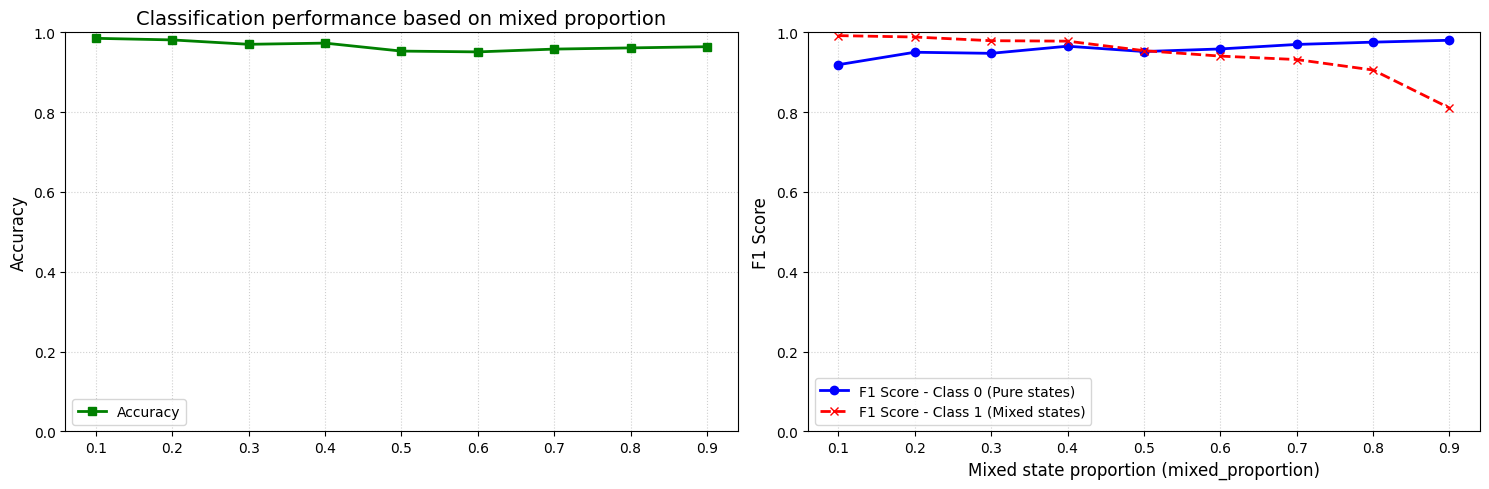

In [33]:
# Display the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

# --- SOUS-GRAPHIQUE 1 : Accuracy ---
ax1.plot(proportion, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance based on mixed proportion", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower left')
ax1.set_ylim(0, 1.0) 

# --- SOUS-GRAPHIQUE 2 : F1 Scores ---

# F1 Score for Class 0 (Pure states)
ax2.plot(proportion, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')

# F1 Score for class 1 (Mixed states)
ax2.plot(proportion, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Mixed state proportion (mixed_proportion)", fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower left')
ax2.set_ylim(0, 1.0) 


plt.tight_layout()

plt.show()

In [34]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_states = [100, 200, 500, 1000, 2000, 5000]

for nstate in n_states:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=N_SHOTS,
    n_states_total=nstate,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)

# Changing dataset size and evaluating
for df in df_array:
    R = df[['X_mean', 'Y_mean', 'Z_mean']].values
    y = df['is_pure'].astype(int).values

    Phi = uhlmann_feature_map(R)   # (n_samples, 5)
    
    Phi_train, Phi_test, y_train, y_test = train_test_split(
        Phi, y,
        test_size=0.2,       # 20% test
        random_state=42,
        stratify=y         
    )
    
    clf = LinearSVC(
        C=1.0,          
        max_iter=10_000
    )

    clf.fit(Phi_train, y_train)

    y_pred = clf.predict(Phi_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

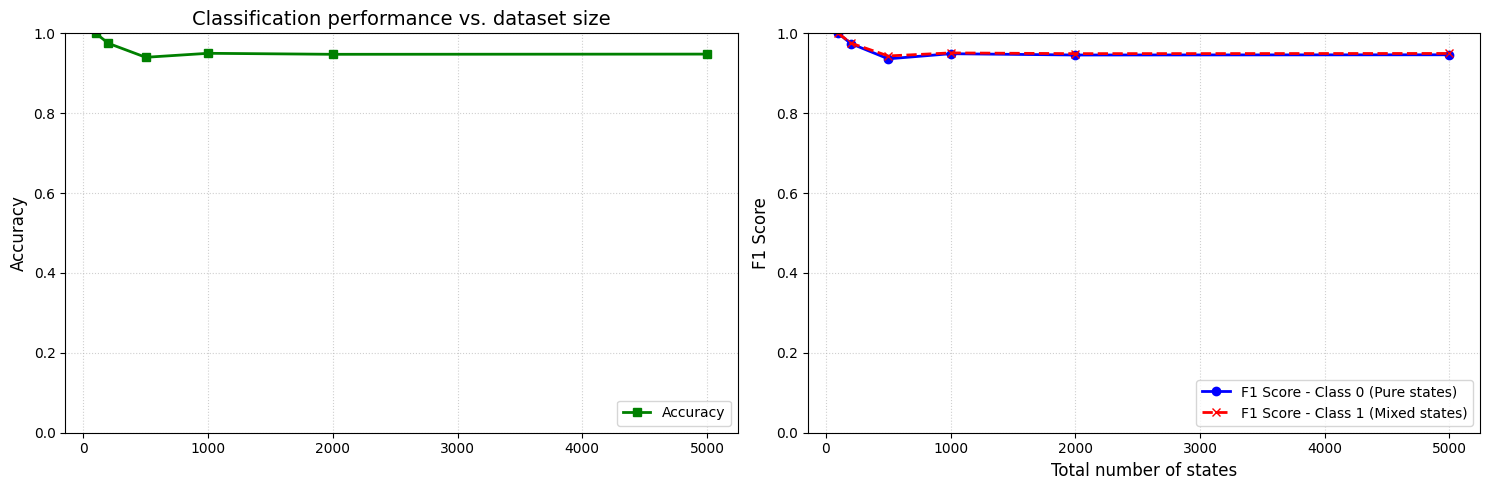

In [35]:
# graph of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

# --- SOUS-GRAPHIQUE 1 : Accuracy ---
ax1.plot(n_states, accs, 
         marker='s', linestyle='-', color='green', linewidth=2, 
         label='Accuracy')

ax1.set_title("Classification performance vs. dataset size", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0) 

# --- SOUS-GRAPHIQUE 2 : F1 Scores ---

# F1 Score for Class 0 (Pure states)
ax2.plot(n_states, f1_score_0, 
         marker='o', linestyle='-', color='blue', linewidth=2, 
         label='F1 Score - Class 0 (Pure states)')

# F1 Score for class 1 (Mixed states)
ax2.plot(n_states, f1_score_1, 
         marker='x', linestyle='--', color='red', linewidth=2, 
         label='F1 Score - Class 1 (Mixed states)')

ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Total number of states", fontsize=12) 
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.0) 

plt.tight_layout() 

plt.show()

In [36]:
df_array = []
accs = []
f1_score_0 = []
f1_score_1 = []

n_shots = [10, 50, 100, 500, 1000, 5000]

for nshot in n_shots:
    df_purity, X, y = build_purity_classification_dataset(
    n_shots=nshot,
    n_states_total=5000,
    mixed_proportion=0.5  # proportion of mixed states
    )
    
    df_array.append(df_purity)

# Changing number of shots and evaluating
for df in df_array:
    R = df[['X_mean', 'Y_mean', 'Z_mean']].values
    y = df['is_pure'].astype(int).values
    Phi = uhlmann_feature_map(R)   # (n_samples, 5)
    
    Phi_train, Phi_test, y_train, y_test = train_test_split(
        Phi, y,
        test_size=0.2,       # 20% test
        random_state=42,
        stratify=y        
    )

    clf = LinearSVC(
        C=1.0,      
        max_iter=10_000
    )
    clf.fit(Phi_train, y_train)

    y_pred = clf.predict(Phi_test)
    
    acc = accuracy_score(y_test, y_pred)
    
    accs.append(acc)

    f1_scores = f1_score(y_test, y_pred, average=None)
    
    f1_score_0.append(f1_scores[0])
    f1_score_1.append(f1_scores[1])

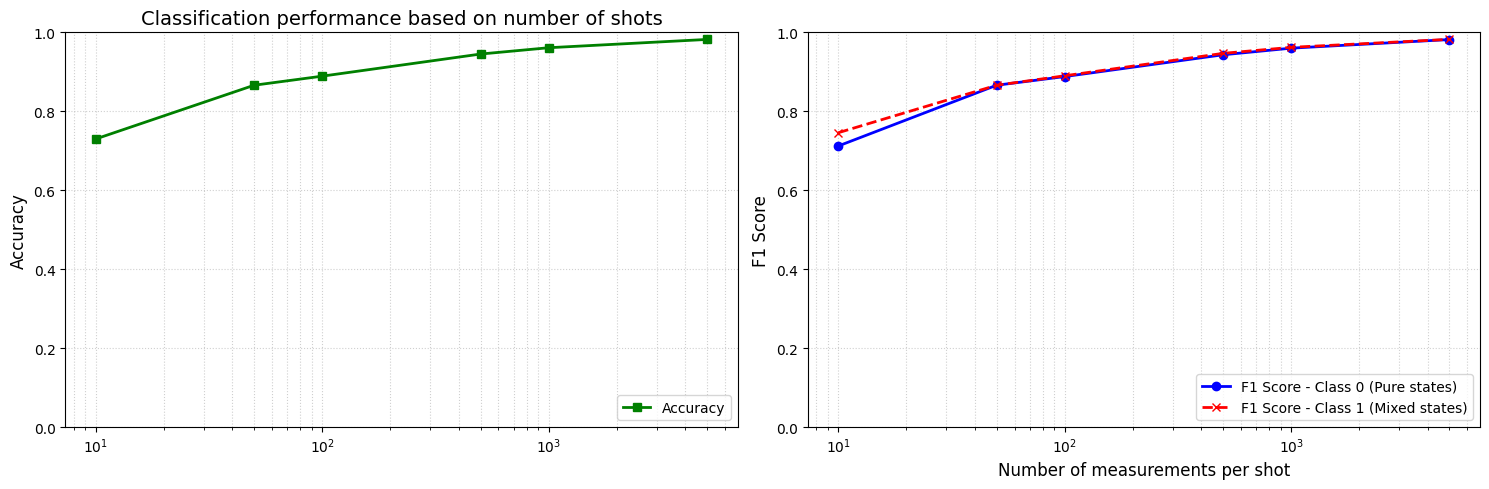

In [37]:
# graph of results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True) 

ax1.semilogx(n_shots, accs, 
             marker='s', linestyle='-', color='green', linewidth=2, 
             label='Accuracy')

ax1.set_title("Classification performance based on number of shots", fontsize=14)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.grid(True, which="both", linestyle=':', alpha=0.6) 
ax1.legend(loc='lower right')
ax1.set_ylim(0, 1.0) 


ax2.semilogx(n_shots, f1_score_0, 
             marker='o', linestyle='-', color='blue', linewidth=2, 
             label='F1 Score - Class 0 (Pure states)')
ax2.semilogx(n_shots, f1_score_1, 
             marker='x', linestyle='--', color='red', linewidth=2, 
             label='F1 Score - Class 1 (Mixed states)')
ax2.set_ylabel("F1 Score", fontsize=12)
ax2.set_xlabel("Number of measurements per shot", fontsize=12) 
ax2.grid(True, which="both", linestyle=':', alpha=0.6)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1.0) 

plt.tight_layout() 

plt.show()